# Анализ пространственных данных. Домашнее задание №1

Данные для выполнения заданий можно найти [здесь](https://yadi.sk/d/xBemeb0ODlhCAQ?w=1)

Дедлайн: __20 октября 2020 г. 09:00__

ФИО: `Машинсон Всеволод Валерьевич`

Группа: `Группа MADE-DS-12`

In [345]:
import pandas as pd
import numpy as np
import math
from shapely.geometry import Point, LineString, MultiPoint
import matplotlib.pyplot as plt
import geopandas as gpd
import os
import earthpy as et 
import seaborn as sns
from matplotlib.ticker import ScalarFormatter
import pysal as ps
import pysal.lib as pslib
import random as rdm
from pylab import *
import mapclassify


# Adjust plot font sizes
sns.set(font_scale=1.5)
sns.set_style("white")

owd = os.getcwd()
# Set working dir & get data
data = et.data.get_data('spatial-vector-lidar')
os.chdir(os.path.join(et.io.HOME, 'earth-analytics'))

# Import world boundary shapefile
worldBound_path = os.path.join("data", "spatial-vector-lidar", "global", 
                               "ne_110m_land", "ne_110m_land.shp")
worldBound = gpd.read_file(worldBound_path)
os.chdir(owd)

def distanceHaversine(lat1, lon1, lat2, lon2):
    R = 6371 # km
    dLat = math.radians(lat2 - lat1)
    dLon = math.radians(lon2 - lon1)
    lat1 = math.radians(lat1)
    lat2 = math.radians(lat2)

    a = math.sin(dLat/2.0) * math.sin(dLat/2.0) + math.sin(dLon/2.0) * math.sin(dLon/2.0) * math.cos(lat1) * math.cos(lat2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = R * c
    
    y = math.sin(dLon) * math.cos(lat2)
    x = math.cos(lat1) * math.sin(lat2) - math.sin(lat1)*math.cos(lat2)*math.cos(dLon)
    brng = math.atan2(y,x)
    return d, (brng/(2*math.pi))*360


def haversineLineLengthInKm(line):
    lat1 = line.coords[0][0]
    lon1 = line.coords[0][1]

    lat2 = line.coords[1][0]
    lon2 = line.coords[1][1]
    
    return distanceHaversine(lat1, lon1, lat2, lon2)[0]

def plotWorld():
    # Plot worldBound data using geopandas
    fig, ax = plt.subplots(figsize=(10, 5))
    worldBound.plot(color='darkgrey', 
                    ax=ax)
    # Set the x and y axis labels
    ax.set(xlabel="Longitude (Degrees)",
           ylabel="Latitude (Degrees)",
           title="Global Map - Geographic Coordinate System - WGS84 Datum\n Units: Degrees - Latitude / Longitude")

    # Add the x y graticules
    ax.set_axisbelow(True)
    ax.yaxis.grid(color='gray', 
                  linestyle='dashed')
    ax.xaxis.grid(color='gray', 
                  linestyle='dashed')
    

## Задание №1. Reading coordinates from a file and creating a geometries. 4 балла.

One of the "classical" problems in GIS is the situation where you have a set of coordinates in a file and you need to get them into a map (or into a GIS-software). Dataset `travelTimes_2015_Helsinki.txt` consist of travel times between specific locations in Helsinki Region.

1. Read the data into memory.
2. Read 4 columns `from_x`, `from_y`, `to_x`, `to_y` from the data.
3. Create two lists called __orig_points__ and __dest_points__
4. Iterate over the rows of your numpy array and add Shapely Point -objects into the __orig_points__ -list and __dest_point__ -list representing the origin locations and destination locations accordingly.

`from_x`: x-coordinate of the __origin__ location (longitude)

`from_y`: y-coordinate of the __origin__ location (latitude)

`to_x`: x-coordinate of the __destination__ location (longitude)

`to_y`: y-coordinate of the __destination__ location (latitude)

In [346]:
# 1 Read the data into memory.
df = pd.read_csv('travelTimes_2015_Helsinki.txt', delimiter=';')

# 2 Read 4 columns `from_x`, `from_y`, `to_x`, `to_y` from the data.
from_x, from_y, to_x, to_y = df.from_x.values, df.from_y.values, df.to_x.values, df.to_y.values

# 3. Create two lists called __orig_points__ and __dest_points__
# 4. Iterate over the rows of your numpy array and add Shapely Point -objects into the 
#    __orig_points__ -list and __dest_point__ -list representing the origin locations and destination locations accordingly.

orig_points = [Point(xy) for xy in np.column_stack((from_y, from_x))] 
dest_points = [Point(xy) for xy in np.column_stack((to_y, to_x))]
assert(len(orig_points) == len(dest_points))

## Задание №2. Creating LineStrings that represent the movements. 6 баллов.

Please use data from previous task:

1. Create a list called `lines`
2. Iterate over the __orig_points__ and __dest_points__ lists and create a Shapely _LineString_ -object between the origin and destination point
3. Add that line into the `lines` -list.
4. Find out what is the average (Euclidian) distance of all the origin-destination _LineStrings_ that we just created, and print it out.

In [347]:
lines = [LineString([xy[0], xy[1]]) for xy in zip(orig_points, dest_points)]
distances = [haversineLineLengthInKm(line) for line in lines]
meanValue = np.asarray(distances).mean()
print(meanValue)

14.07760631349913


## Задание №3. Points to map. 4 балла.

Aim is to plot a set of x and y coordinates that we should read from a `some_posts.csv`. The data has 81379 rows and consists of locations and times of social media posts inside Kruger national park in South Africa.

1. Read the data into memory.
2. Create an empty column called `geometry` where you will store shapely _Point_ objects
3. Iterate over the rows of the DataFrame (__x__ and __y__ -coordinates) and insert _Point_ objects into column `geometry`
4. Convert that DataFrame into a GeoDataFrame
5. Update the CRS for coordinate system as WGS84 (i.e. epsg code: 4326)
6. Save the data into a Shapefile called `Kruger_posts.shp`
7. Create a simple map of those points using .plot() -funtion

`lat`: y-coordinate of the post

`lon`: x-coordinate of the post

`timestamp`: Time when the post was uploaded

`userid`: userid

In [348]:
somePosts = pd.read_csv('some_posts.txt', delimiter=',')
somePosts["geometry"] = np.nan
somePosts["geometry"] = [Point(xy) for xy in np.column_stack((somePosts.lat, somePosts.lon))] 
somePostsGeoDataFrame = gpd.GeoDataFrame(somePosts)
somePostsGeoDataFrame.crs = "EPSG:4326"
somePostsGeoDataFrame.to_file("Kruger_posts.shp")
somePostsGeoDataFrame.head(10)

lat        lon         timestamp    userid  \
0 -24.980792  31.484633  2015-07-07 03:02  66487960   
1 -25.499225  31.508906  2015-07-07 03:18  65281761   
2 -24.342578  30.930866  2015-03-07 03:38  90916112   
3 -24.854614  31.519718  2015-10-07 05:04  37959089   
4 -24.921069  31.520836  2015-10-07 05:19  27793716   
5 -24.047833  31.687000  2015-05-07 05:55  88751696   
6 -24.044000  31.687000  2015-03-07 05:57  88751696   
7 -25.498371  30.983844  2015-09-07 06:21  52431146   
8 -24.342279  30.990728  2015-07-07 07:15  11505530   
9 -25.413386  31.159930  2015-11-07 07:17  24990235   

                     geometry  
0  POINT (-24.98079 31.48463)  
1  POINT (-25.49922 31.50891)  
2  POINT (-24.34258 30.93087)  
3  POINT (-24.85461 31.51972)  
4  POINT (-24.92107 31.52084)  
5  POINT (-24.04783 31.68700)  
6  POINT (-24.04400 31.68700)  
7  POINT (-25.49837 30.98384)  
8  POINT (-24.34228 30.99073)  
9  POINT (-25.41339 31.15993)

<AxesSubplot:>

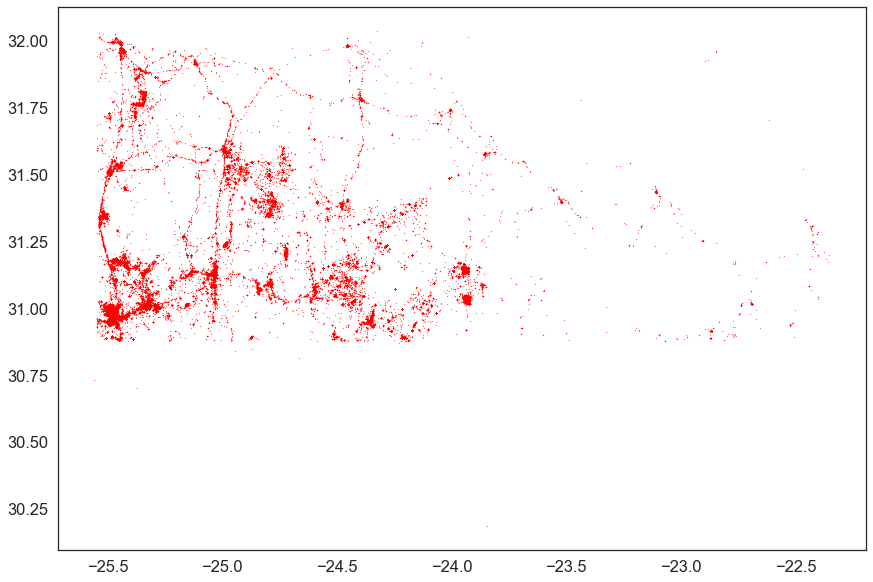

In [349]:
somePostsGeoDataFrame.plot(markersize=0.05, figsize=(20,10), color='red')

## Задание №4. Movements of individual user. 6 баллов.

Please use data from previous task:

1. Group the data by `userid`
2. Create an empty GeoDataFrame
3. For each user:
   - sort the rows by `timestamp`
   - create _LineString_ objects based on the points
   - add the `geometry` and the `userid` into the GeoDataFrame you created in the last step
4. Determine the CRS of your GeoDataFrame to WGS84 (epsg code: 4326)
5. Save the movements of each user into a separate Shapefile
   - Name the output Shapefile based on the `userid` number

In [350]:
somePostsGeoDataFrameSorted = (somePostsGeoDataFrame.sort_values(by=['userid', 'timestamp']))[["userid", "geometry"]]
somePostsGeoDataFrameSorted = somePostsGeoDataFrameSorted.groupby('userid').filter(lambda x: len(list(x['geometry'])) > 1)
somePostsGeoDataFrameSorted = somePostsGeoDataFrameSorted.groupby('userid').apply(lambda x: LineString(list(x['geometry'])))
somePostsGeoDataFrameSorted = pd.DataFrame(somePostsGeoDataFrameSorted)
somePostsGeoDataFrameSorted.reset_index(level=0, inplace=True)
somePostsGeoDataFrameSorted.columns = ["userid", "geometry"]
geo = gpd.GeoDataFrame(somePostsGeoDataFrameSorted)
geo.crs = "EPSG:4326"
records = geo.to_records()
records
userCount = 5 #geo.size
for i in range(userCount):
    index, user_id, geometry = records[i]
    userId = records[i]
    somePostsGeoDataFrame.to_file(f"{user_id}.shp")


In [351]:
geo.head(10)

userid                                           geometry
0   16301  LINESTRING (-24.75951 31.37120, -24.74985 31.3...
1   45136  LINESTRING (-25.32131 31.02582, -25.32131 31.0...
2   50136  LINESTRING (-24.76985 31.39447, -24.99253 31.5...
3   88775  LINESTRING (-25.32947 31.00036, -25.32947 31.0...
4   88918  LINESTRING (-25.06714 31.55131, -24.99253 31.5...
5   90156  LINESTRING (-24.86016 31.40124, -24.86012 31.4...
6  174181  LINESTRING (-25.48673 31.15077, -25.48673 31.1...
7  177600  LINESTRING (-24.29767 31.28550, -24.30217 31.3...
8  181216  LINESTRING (-24.79546 31.50228, -24.79587 31.5...
9  184404  LINESTRING (-25.03265 31.11970, -25.03643 31.1...

## Задание №5. Join accessibility datasets into a grid and visualize them by using a classifier. 4 балла.

A dataset from `dataE4.zip` includes 7 text files containing data about accessibility in Helsinki Region and a Shapefile that contains a Polygon grid that can be used to visualize and analyze the data spatially. The datasets are:

 - `travel_times_to_[XXXXXXX]_[NAME-OF-THE-CENTER].txt` including travel times and road network distances to specific shopping center
 - `MetropAccess_YKR_grid_EurefFIN.shp` including the Polygon grid with __YKR_ID__ column that can be used to join the grid with the accessibility data
 
Find out more about the data [here](https://blogs.helsinki.fi/accessibility/helsinki-region-travel-time-matrix-2015/)

1. Read those travel_time data files (one by one) with Pandas and select only following columns from them:

 - `pt_r_tt`
 - `car_r_t`
 - `from_id`
 - `to_id`


2. Visualize the classified travel times (Public transport AND Car) of at least one of the shopping centers using any classification method (see [PySAL](https://pysal.org/) for more details upon classification methods). You need to classify the data into a new column in your GeoDataFrame.

In [352]:
rootPath = "dataE4"
columnsForSelection = ['pt_r_tt','car_r_t','from_id','to_id']
jumbo = pd.read_csv(f'{rootPath}/TravelTimes_to_5878070_Jumbo.txt', delimiter=';')
dixi = pd.read_csv(f'{rootPath}/TravelTimes_to_5878087_Dixi.txt', delimiter=';')
myyrmanni = pd.read_csv(f'{rootPath}/TravelTimes_to_5902043_Myyrmanni.txt', delimiter=';')
itis = pd.read_csv(f'{rootPath}/TravelTimes_to_5944003_Itis.txt', delimiter=';')
forum = pd.read_csv(f'{rootPath}/TravelTimes_to_5975373_Forum.txt', delimiter=';')
omena = pd.read_csv(f'{rootPath}/TravelTimes_to_5978593_Iso_omena.txt', delimiter=';')
ruoholahti = pd.read_csv(f'{rootPath}/TravelTimes_to_5980260_Ruoholahti.txt', delimiter=';')

#filter negative ids
shoppingCenters = [df[columnsForSelection] for df in [jumbo, dixi, myyrmanni, itis, forum, omena, ruoholahti]]
shoppingCenters = [df[df.to_id > 0] for df in shoppingCenters]
shoppingCenters = [df[df.from_id > 0] for df in shoppingCenters]
shapeLink = f'{rootPath}/MetropAccess_YKR_grid_EurefFIN.shp'
tx = gpd.read_file(shapeLink)


#For jumbo center classification
joined = gpd.GeoDataFrame(pd.merge(shoppingCenters[0], tx, left_on='from_id', right_on='YKR_ID'))

classifierCar = mapclassify.FisherJenks(joined.car_r_t, k=10)
classifierPublis = mapclassify.FisherJenks(joined.pt_r_tt, k=10)

joined["classified_car"] = classifierCar(joined.car_r_t)
joined["classifier_publics"] = classifierCar(joined.pt_r_tt)
joined.head(10)

pt_r_tt  car_r_t  from_id    to_id         x          y   YKR_ID  \
0      131       39  5785640  5878070  381875.0  6697880.0  5785640   
1      129       39  5785641  5878070  382125.0  6697880.0  5785641   
2      129       45  5785642  5878070  382375.0  6697880.0  5785642   
3      138       46  5785643  5878070  382625.0  6697880.0  5785643   
4      115       38  5787544  5878070  381125.0  6697630.0  5787544   
5      115       41  5787545  5878070  381375.0  6697630.0  5787545   
6      131       42  5787546  5878070  381625.0  6697630.0  5787546   
7      137       41  5787547  5878070  381875.0  6697630.0  5787547   
8      129       40  5787548  5878070  382125.0  6697630.0  5787548   
9      137       42  5787549  5878070  382375.0  6697630.0  5787549   

                                            geometry  classified_car  \
0  POLYGON ((382000.000 6697750.000, 381750.000 6...               6   
1  POLYGON ((382250.000 6697750.000, 382000.000 6...               6   
2  POLYGON ((382500.000 6697750.000, 382250.000 6...               7   
3  POLYGON ((382750.000 6697750.000, 382500.000 6...               7   
4  POLYGON ((381250.000 6697500.000, 381000.000 6...               5   
5  POLYGON ((381500.000 6697500.000, 381250.000 6...               6   
6  POLYGON ((381750.000 6697500.000, 381500.000 6...               6   
7  POLYGON ((382000.000 6697500.000, 381750.000 6...               6   
8  POLYGON ((382250.000 6697500.000, 382000.000 6...               6   
9  POLYGON ((382500.000 6697500.000, 382250.000 6...               6   

   classifier_publics  
0                   9  
1                   9  
2                   9  
3                   9  
4                   9  
5                   9  
6                   9  
7                   9  
8                   9  
9                   9

In [353]:
classifierCar.plot(joined)

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

In [354]:
classifierPublis.plot(joined)

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

## Задание №6. Calculate and visualize the dominance areas of shopping centers. 6 баллов.

Please use data from previous task. The aim is to define the dominance area for each of those shopping centers based on travel time:

1. Iterate over the accessibility files one by one
2. Rename the travel time columns so that they can be identified
   - you can include e.g. the `to_id` number as part of the column name (then the column name could be e.g. "pt_r_tt_5987221")
3. Join those columns into `MetropAccess_YKR_grid_EurefFIN.shp` where __YKR_ID__ in the grid corresponds to `from_id` in the travel time data file. At the end you should have a GeoDataFrame with different columns show the travel times to different shopping centers.
4. For each row find out the __minimum__ value of __all__ `pt_r_tt_XXXXXX` columns and insert that value into a new column called `min_time_pt`. You can now also parse the `to_id` value from the column name (i.e. parse the last number-series from the column text) that had the minimum travel time value and insert that value as a number into a column called `dominant_service`. In this, way are able to determine the "closest" shopping center for each grid cell and visualize it either by travel times or by using the __YKR_ID__ number of the shopping center (i.e. that number series that was used in column name).
5. Visualize the travel times of our `min_time_pt` column using any classifier.
6. Visualize also the values in `dominant_service` column (no need to use any specific classifier). Notice that the value should be a number. If it is still as text, you need to convert it first.

In [385]:
rootPath = "dataE4"

jumbo = pd.read_csv(f'{rootPath}/TravelTimes_to_5878070_Jumbo.txt', delimiter=';')
dixi = pd.read_csv(f'{rootPath}/TravelTimes_to_5878087_Dixi.txt', delimiter=';')
myyrmanni = pd.read_csv(f'{rootPath}/TravelTimes_to_5902043_Myyrmanni.txt', delimiter=';')
itis = pd.read_csv(f'{rootPath}/TravelTimes_to_5944003_Itis.txt', delimiter=';')
forum = pd.read_csv(f'{rootPath}/TravelTimes_to_5975373_Forum.txt', delimiter=';')
omena = pd.read_csv(f'{rootPath}/TravelTimes_to_5978593_Iso_omena.txt', delimiter=';')
ruoholahti = pd.read_csv(f'{rootPath}/TravelTimes_to_5980260_Ruoholahti.txt', delimiter=';')

centers = [jumbo, dixi, myyrmanni, itis, forum, omena, ruoholahti]
ids = [5878070, 5878087, 5902043, 5944003, 5975373, 5978593, 5980260]
tx = gpd.read_file(shapeLink)[["geometry", "YKR_ID"]]

joined = gpd.GeoDataFrame(pd.merge(shoppingCenters[0], tx, left_on='from_id', right_on='YKR_ID'))
comboDataFrame = pd.DataFrame()
for i, center_id in enumerate(ids):
    pName = f'pt_r_tt_{center_id}'
    centers[i].rename(columns={"pt_r_tt": pName}, inplace=True)
    centers[i] = centers[i][centers[i].to_id > 0]
    centers[i] = centers[i][centers[i].from_id > 0]
    tx = pd.merge(centers[i][[pName, "from_id"]], tx, left_on='from_id', right_on='YKR_ID')
    tx.drop(columns=['from_id'],inplace=True)
  
def minColumnValue(row):
    minId = 0
    minValue = 1e9
    
    for center_id in ids:
        colName = f'pt_r_tt_{center_id}'
        if row[colName] < minValue:
            minId = center_id
            minValue = row[colName]
            
    return (minValue, minId)

tx['min_time_pt'] = tx.apply(lambda row: minColumnValue(row)[0], axis=1)
tx['dominant_service'] = tx.apply(lambda row: minColumnValue(row)[1], axis=1)
tx = gpd.GeoDataFrame(tx)
tx.head(10)

pt_r_tt_5980260  pt_r_tt_5978593  pt_r_tt_5975373  pt_r_tt_5944003  \
0              147              166              137              157   
1              142              164              134              154   
2              142              164              134              154   
3              153              174              144              163   
4              130              150              121              142   
5              130              150              121              142   
6              147              166              137              157   
7              150              172              142              162   
8              143              165              135              154   
9              150              172              142              162   

   pt_r_tt_5902043  pt_r_tt_5878087  pt_r_tt_5878070  \
0              121              134              131   
1              115              130              129   
2              115              130              129   
3              126              140              138   
4              103              118              115   
5              103              118              115   
6              121              134              131   
7              123              138              137   
8              115              130              129   
9              123              138              137   

                                            geometry   YKR_ID  min_time_pt  \
0  POLYGON ((382000.000 6697750.000, 381750.000 6...  5785640          121   
1  POLYGON ((382250.000 6697750.000, 382000.000 6...  5785641          115   
2  POLYGON ((382500.000 6697750.000, 382250.000 6...  5785642          115   
3  POLYGON ((382750.000 6697750.000, 382500.000 6...  5785643          126   
4  POLYGON ((381250.000 6697500.000, 381000.000 6...  5787544          103   
5  POLYGON ((381500.000 6697500.000, 381250.000 6...  5787545          103   
6  POLYGON ((381750.000 6697500.000, 381500.000 6...  5787546          121   
7  POLYGON ((382000.000 6697500.000, 381750.000 6...  5787547          123   
8  POLYGON ((382250.000 6697500.000, 382000.000 6...  5787548          115   
9  POLYGON ((382500.000 6697500.000, 382250.000 6...  5787549          123   

   dominant_service  
0           5902043  
1           5902043  
2           5902043  
3           5902043  
4           5902043  
5           5902043  
6           5902043  
7           5902043  
8           5902043  
9           5902043

In [356]:
classifier = mapclassify.FisherJenks(tx.min_time_pt, k=10)
classifier.plot(tx)

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

In [384]:
tx.plot(column='dominant_service', figsize=(16, 9),  cmap='jet', alpha=1, linewidth=0.0)

<AxesSubplot:>